In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Dot, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf


# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
}

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2021-10-18 17:00:00']
test_data = df_for_training.loc['2021-10-18 17:00:00':'2021-10-20 17:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 48  # Two days of data (24 hours per day, assuming hourly data)
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)

# Define the architecture of the Bi-LSTM encoder-decoder model with attention
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
decoder_inputs = Input(shape=(n_steps, n_features))
decoder = Bidirectional(LSTM(64, return_sequences=True))(decoder_inputs)
attention = Dot(axes=[2, 2])([decoder, encoder])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder])
decoder_combined_context = Concatenate(axis=-1)([context, decoder])
decoder_outputs = Dense(1)(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', run_eagerly=True)  # Set run_eagerly=True

# Train the model
model.fit([train_X, train_X], train_y, epochs=10, batch_size=16)

# Make predictions on the test data
test_predictions = model.predict([test_X, test_X])

Epoch 1/10


C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 7s 450ms/step - loss: 0.0965
Epoch 2/10
15/15 [==============================] - 7s 436ms/step - loss: 0.0373
Epoch 3/10
15/15 [==============================] - 7s 446ms/step - loss: 0.0197
Epoch 4/10
15/15 [==============================] - 7s 435ms/step - loss: 0.0128
Epoch 5/10
15/15 [==============================] - 7s 436ms/step - loss: 0.0107
Epoch 6/10
15/15 [==============================] - 7s 447ms/step - loss: 0.0093
Epoch 7/10
15/15 [==============================] - 7s 434ms/step - loss: 0.0075
Epoch 8/10
15/15 [==============================] - 7s 438ms/step - loss: 0.0125
Epoch 9/10
15/15 [==============================] - 7s 436ms/step - loss: 0.0142
Epoch 10/10
15/15 [==============================] - 7s 447ms/step - loss: 0.0137


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Dot, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
}

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2021-10-18 17:00:00']
test_data = df_for_training.loc['2021-10-18 17:00:00':'2021-10-20 17:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 48  # Two days of data (24 hours per day, assuming hourly data)
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)

# Define the architecture of the Bi-LSTM encoder-decoder model with attention
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
decoder_inputs = Input(shape=(n_steps, n_features))
decoder = Bidirectional(LSTM(64, return_sequences=True))(decoder_inputs)
attention = Dot(axes=[2, 2])([decoder, encoder])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder])
decoder_combined_context = Concatenate(axis=-1)([context, decoder])
decoder_outputs = Dense(1)(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit([train_X, train_X], train_y, epochs=10, batch_size=16)

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Make predictions on the test data
test_predictions = model.predict([test_X, test_X])
test_predictions.shape


Epoch 1/10


C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 7s 441ms/step - loss: 0.1417
Epoch 2/10
15/15 [==============================] - 6s 429ms/step - loss: 0.0412
Epoch 3/10
15/15 [==============================] - 6s 433ms/step - loss: 0.0219
Epoch 4/10
15/15 [==============================] - 7s 440ms/step - loss: 0.0110
Epoch 5/10
15/15 [==============================] - 6s 428ms/step - loss: 0.0070
Epoch 6/10
15/15 [==============================] - 6s 429ms/step - loss: 0.0083
Epoch 7/10
15/15 [==============================] - 7s 437ms/step - loss: 0.0110
Epoch 8/10
15/15 [==============================] - 6s 430ms/step - loss: 0.0126
Epoch 9/10
15/15 [==============================] - 7s 438ms/step - loss: 0.0059
Epoch 10/10
15/15 [==============================] - 6s 429ms/step - loss: 0.0080


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Dot, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2021-10-14 17:00:00']
test_data = df_for_training.loc['2021-10-14 17:00:00':'2021-10-21 19:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 48
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)

# Define the architecture of the Bi-LSTM encoder-decoder model with attention
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
decoder_inputs = Input(shape=(n_steps, n_features))
decoder = Bidirectional(LSTM(64, return_sequences=True))(decoder_inputs)
attention = Dot(axes=[2, 2])([decoder, encoder])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder])
decoder_combined_context = Concatenate(axis=-1)([context, decoder])
decoder_outputs = Dense(1)(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit([train_X, train_X], train_y, epochs=10, batch_size=16)

# Make predictions on the test data
test_predictions = model.predict([test_X, test_X])
test_predictions.shape

Epoch 1/10
14/14 [==============================] - 5s 19ms/step - loss: 0.1049
Epoch 2/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0390
Epoch 3/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0246
Epoch 4/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0083
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0081
Epoch 7/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0119
Epoch 8/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0083
Epoch 9/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0058
Epoch 10/10
1/1 [==============================] - 1s 943ms/step


(12, 48, 1)

In [42]:
forecast_copies = np.repeat(test_predictions,df_for_training.shape[1],axis=-1)

In [43]:
forecast_copies = np.mean(forecast_copies,axis = 1)
forecast_copies.shape

(12, 26)

In [44]:
test_predictions = scaler.inverse_transform(flattened_predictions)

ValueError: Index data must be 1-dimensional

In [40]:
# Reshape the predicted values to match the desired shape
reshaped_predictions = test_predictions.reshape(test_predictions.shape[0], n_steps, n_features)
reshaped_predictions = reshaped_predictions[:, -1, :]

# Inverse transform the reshaped predictions
inverse_predictions = scaler.inverse_transform(reshaped_predictions)

# Convert the predicted values to DataFrame
predicted_df = pd.DataFrame(inverse_predictions, columns=df_for_training.columns)

# Set the index of the predicted DataFrame
predicted_df.index = test_data.index[n_steps:]

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()


ValueError: cannot reshape array of size 14976 into shape (576,48,26)

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense
from tensorflow.keras.optimizers import Adam

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2022-05-15 23:00:00']
test_data = df_for_training.loc['2022-05-15 23:00:00':'2022-08-20 19:00:00']

# Normalize the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 12
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc(target_variable)])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc(target_variable)])
test_X, test_y = np.array(test_X), np.array(test_y)

# Define and train the TCN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(train_X, train_y, epochs=10, batch_size=16)

# Make predictions on the test data
test_predictions = model.predict(test_X)

# Reshape test_predictions to match the shape of the original scaled data
test_predictions = test_predictions.reshape(-1, n_features)

# Inverse scaling
test_predictions = scaler.inverse_transform(test_predictions)

# Convert the predictions and ground truth to pandas DataFrame for visualization
predicted_df = pd.DataFrame(test_predictions, index=test_data.index[n_steps:n_steps + len(test_predictions)], columns=df_for_training.columns)
actual_df = pd.DataFrame(test_y, index=test_data.index[n_steps:], columns=[target_variable])
# Find the intersection points
intersections = predicted_df[predicted_df.eq(actual_df.shift())].dropna()

# Plot the predicted and actual values with intersection points
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.plot(actual_df.index, actual_df[target_variable], label='Actual')
plt.scatter(intersections.index, intersections[target_variable], color='red', label='Intersection')

# Set y-axis limits to only show values of 0 and 1
plt.ylim([-0.1, 1.1])

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction with Intersection Points')
plt.legend()
plt.show()


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Niranjan\AppData\Local\Temp\ipykernel_19440\3138634782.py", line 54, in <module>
      model.fit(train_X, train_y, epochs=10, batch_size=16)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\Niranjan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [16,6,26] vs. [16]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_5352934]

Transfomer model for time Series

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2022-05-15 23:00:00']
test_data = df_for_training.loc['2022-05-15 23:00:00':'2022-08-20 19:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 26
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)
# Define the architecture of the Transformer model
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = layers.Dropout(0.1)(encoder_inputs)
encoder = layers.Dense(64, activation="relu")(encoder)
encoder = layers.Dense(32, activation="relu")(encoder)

decoder_inputs = layers.Dense(32, activation="relu")(encoder)
decoder = layers.Dense(64, activation="relu")(decoder_inputs)
decoder = layers.Dense(n_features)(decoder)

# Define the model
model = Model(encoder_inputs, decoder)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit(train_X, train_X, epochs=10, batch_size=16, validation_data=(test_X, test_X), 
          callbacks=[EarlyStopping(patience=3)], verbose=1)

# Make predictions on the test data
test_predictions = model.predict(test_X)

# Invert the scaling of the predicted values (same as in your code)
test_predictions = scaler.inverse_transform(test_predictions)
test_predictions = np.clip(test_predictions, 0, 1)
predicted_df = pd.DataFrame(test_predictions, columns=df_for_training.columns, index=test_data.index[n_steps:])

# Plot the predicted values (same as in your code)
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()

Epoch 1/10
127/127 [==============================] - 1s 4ms/step - loss: 0.1865 - val_loss: 0.2219
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.1290
Epoch 3/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.1085
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.1065
Epoch 5/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.1016
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.1035
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.1000
Epoch 8/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0983
Epoch 9/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0993
Epoch 10/10
27/27 [==============================] - 0s 1ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2022-05-15 23:00:00']
test_data = df_for_training.loc['2022-05-15 23:00:00':'2022-08-20 19:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 26
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)
# Define the architecture of the Transformer model
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = layers.Dropout(0.1)(encoder_inputs)
encoder = layers.Dense(64, activation="relu")(encoder)
encoder = layers.Dense(32, activation="relu")(encoder)

decoder_inputs = layers.Dense(32, activation="relu")(encoder)
decoder = layers.Dense(64, activation="relu")(decoder_inputs)
decoder = layers.Dense(n_features)(decoder)

# Define the model
model = Model(encoder_inputs, decoder)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit(train_X, train_X, epochs=10, batch_size=16, validation_data=(test_X, test_X), 
          callbacks=[EarlyStopping(patience=3)], verbose=1)

# Make predictions on the test data
test_predictions = model.predict(test_X)

Epoch 1/10
127/127 [==============================] - 1s 3ms/step - loss: 0.1397 - val_loss: 0.1584
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0974
Epoch 3/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0962
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0925
Epoch 5/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0930
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0913
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0930
Epoch 8/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0936
Epoch 9/10
127/127 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0908
Epoch 10/10
27/27 [==============================] - 0s 1ms/step


In [60]:
test_predictions.shape

(838, 26, 26)

In [61]:
array_2d = np.mean(test_predictions,axis = 1)
array_2d.shape

(838, 26)

In [56]:
test_predictions.shape

(21788, 26)

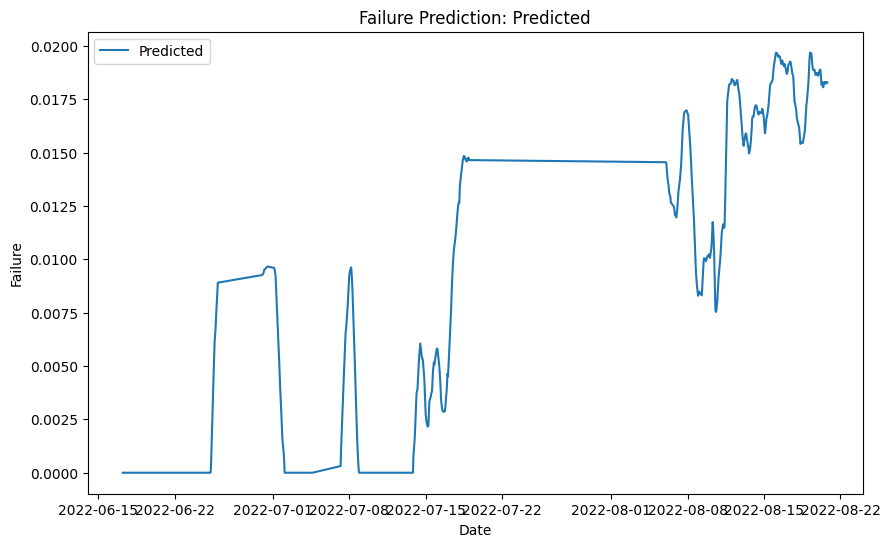

In [62]:
# Invert the scaling of the predicted values (same as in your code)
test_predictions = scaler.inverse_transform(array_2d)
test_predictions = np.clip(test_predictions, 0, 1)
predicted_df = pd.DataFrame(test_predictions, columns=df_for_training.columns, index=test_data.index[n_steps:])

# Plot the predicted values (same as in your code)
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()

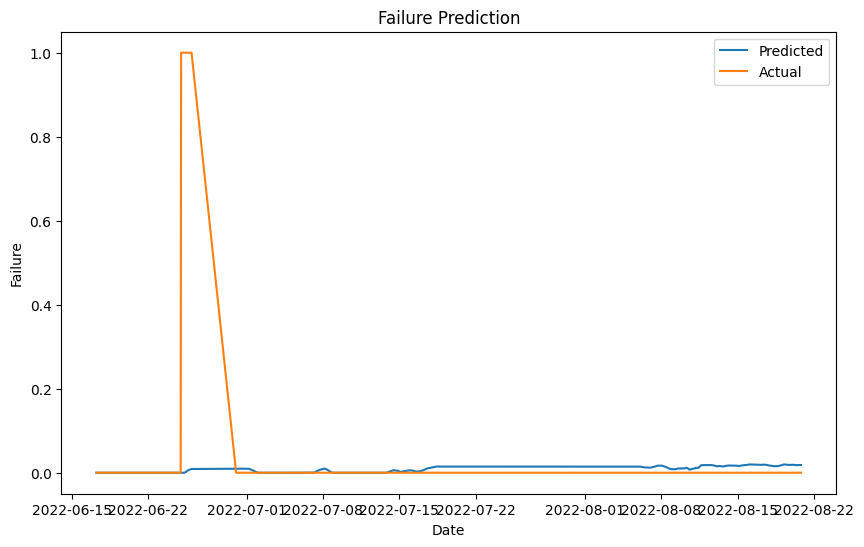

In [63]:
# Create a DataFrame for the actual values
actual_df = pd.DataFrame(test_y, columns=[target_variable], index=test_data.index[n_steps:])

# Plot the predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.plot(actual_df.index, actual_df[target_variable], label='Actual')

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction')
plt.legend()
plt.show()


In [64]:
from sklearn.metrics import accuracy_score

# Align the indices of test data and predicted values
test_data = test_data[n_steps:]
predicted_df = predicted_df[:len(test_data)]

# Convert the failure values to binary (0 or 1)
test_labels = test_data['Failure'].apply(lambda x: 1 if x >= 0.5 else 0)
predicted_labels = predicted_df['Failure'].apply(lambda x: 1 if x >= 0.5 else 0)

accuracy = accuracy_score(test_labels, predicted_labels)
accuracyx

0.9725536992840096

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2021-10-18 17:00:00']
test_data = df_for_training.loc['2021-10-18 17:00:00':'2021-11-20 15:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 48
n_features = df_for_training.shape[1]

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    train_X.append(train_data_scaled[i - n_steps:i])
    train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)
# Define the architecture of the Transformer model
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = layers.Dropout(0.1)(encoder_inputs)
encoder = layers.Dense(64, activation="relu")(encoder)
encoder = layers.Dense(32, activation="relu")(encoder)

decoder_inputs = layers.Dense(32, activation="relu")(encoder)
decoder = layers.Dense(64, activation="relu")(decoder_inputs)
decoder = layers.Dense(n_features)(decoder)

# Define the model
model = Model(encoder_inputs, decoder)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit(train_X, train_X, epochs=10, batch_size=16, validation_data=(test_X, test_X), 
          callbacks=[EarlyStopping(patience=3)], verbose=1)

# Make predictions on the test data
test_predictions = model.predict(test_X)

Epoch 1/10
15/15 [==============================] - 1s 12ms/step - loss: 0.2245 - val_loss: 0.2382
Epoch 2/10
15/15 [==============================] - 0s 5ms/step - loss: 0.1746 - val_loss: 0.1685
Epoch 3/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0946 - val_loss: 0.1232
Epoch 4/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0697 - val_loss: 0.1071
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0653 - val_loss: 0.1068
Epoch 6/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0624 - val_loss: 0.1095
Epoch 7/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0601 - val_loss: 0.1058
Epoch 8/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.1019
Epoch 9/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0540 - val_loss: 0.0994
Epoch 10/10
13/13 [==============================] - 0s 1ms/step


In [6]:
test_predictions.shape

(416, 48, 26)

In [7]:
array_2d = np.mean(test_predictions,axis = 1)
array_2d.shape

(416, 26)

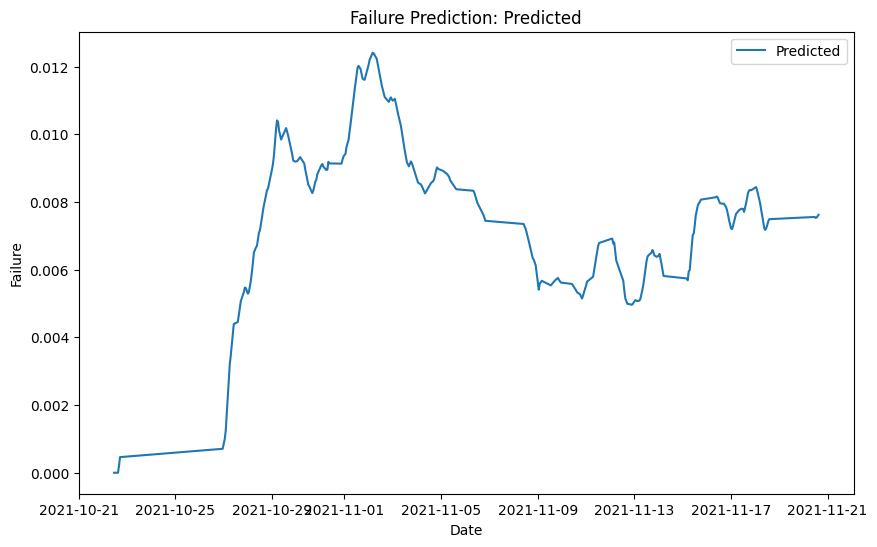

In [8]:
# Invert the scaling of the predicted values (same as in your code)
test_predictions = scaler.inverse_transform(array_2d)
test_predictions = np.clip(test_predictions, 0, 1)
predicted_df = pd.DataFrame(test_predictions, columns=df_for_training.columns, index=test_data.index[n_steps:])

# Plot the predicted values (same as in your code)
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()

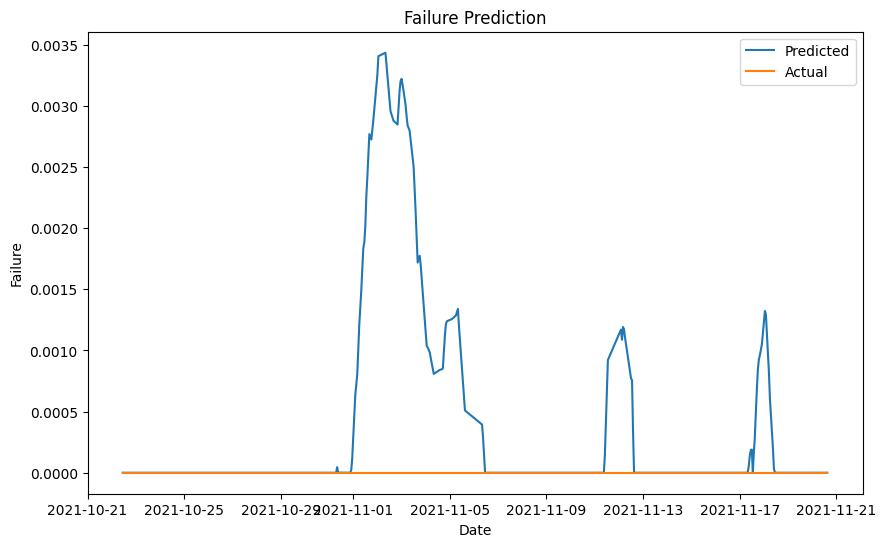

In [74]:
# Create a DataFrame for the actual values
actual_df = pd.DataFrame(test_y, columns=[target_variable], index=test_data.index[n_steps:])

# Plot the predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.plot(actual_df.index, actual_df[target_variable], label='Actual')

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction')
plt.legend()
plt.show()


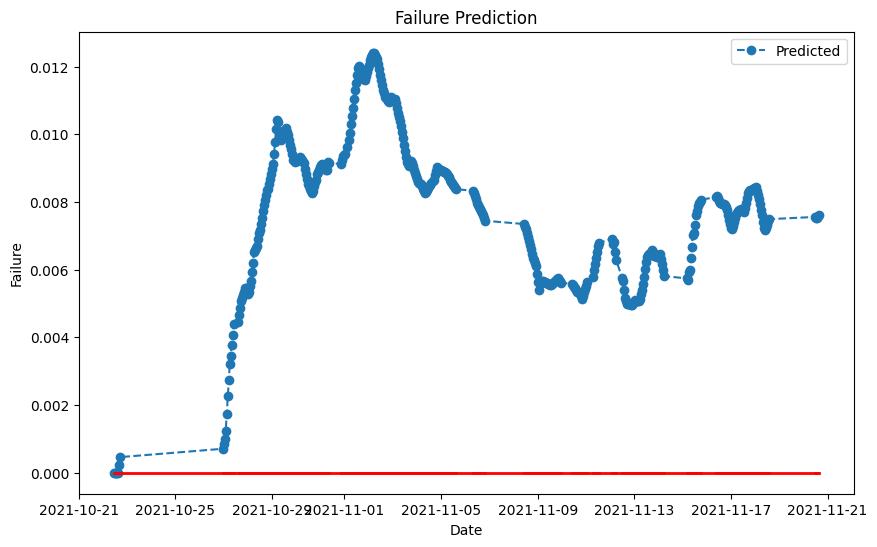

In [9]:
# Create a DataFrame for the actual values
actual_df = pd.DataFrame(test_y, columns=[target_variable], index=test_data.index[n_steps:])

# Plot the predicted and actual values with gaps
plt.figure(figsize=(10, 6))

# Plot the predicted values as a discontinuous line
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted', marker='o', linestyle='dashed')

# Plot the actual values as separate segments
for start, end in zip(actual_df.index[:-1], actual_df.index[1:]):
    plt.plot([start, end], [actual_df.loc[start, target_variable], actual_df.loc[start, target_variable]], color='red', linestyle='solid', linewidth=2)

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction')
plt.legend()
plt.show()


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2021-10-18 17:00:00']
test_data = df_for_training.loc['2021-10-18 17:00:00':'2021-11-20 15:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_days = 10
n_steps = n_days * 24

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    if (train_data.index[i] - train_data.index[i - n_steps]).days >= n_days:
        train_X.append(train_data_scaled[i - n_steps:i])
        train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    if (test_data.index[i] - test_data.index[i - n_steps]).days >= n_days:
        test_X.append(test_data_scaled[i - n_steps:i])
        test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)
# Define the architecture of the Transformer model
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = layers.Dropout(0.1)(encoder_inputs)
encoder = layers.Dense(64, activation="relu")(encoder)
encoder = layers.Dense(32, activation="relu")(encoder)

decoder_inputs = layers.Dense(32, activation="relu")(encoder)
decoder = layers.Dense(64, activation="relu")(decoder_inputs)
decoder = layers.Dense(n_features)(decoder)

# Define the model
model = Model(encoder_inputs, decoder)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit(train_X, train_X, epochs=10, batch_size=16, validation_data=(test_X, test_X), 
          callbacks=[EarlyStopping(patience=3)], verbose=1)

# Make predictions on the test data
test_predictions = model.predict(test_X)

Epoch 1/10
3/3 [==============================] - 1s 70ms/step - loss: 0.2557 - val_loss: 0.2773
Epoch 2/10
3/3 [==============================] - 0s 26ms/step - loss: 0.2377 - val_loss: 0.2616
Epoch 3/10
3/3 [==============================] - 0s 29ms/step - loss: 0.2281 - val_loss: 0.2515
Epoch 4/10
3/3 [==============================] - 0s 29ms/step - loss: 0.2225 - val_loss: 0.2456
Epoch 5/10
3/3 [==============================] - 0s 35ms/step - loss: 0.2179 - val_loss: 0.2396
Epoch 6/10
3/3 [==============================] - 0s 33ms/step - loss: 0.2130 - val_loss: 0.2328
Epoch 7/10
3/3 [==============================] - 0s 28ms/step - loss: 0.2071 - val_loss: 0.2259
Epoch 8/10
3/3 [==============================] - 0s 26ms/step - loss: 0.1997 - val_loss: 0.2172
Epoch 9/10
3/3 [==============================] - 0s 25ms/step - loss: 0.1901 - val_loss: 0.2057
Epoch 10/10
7/7 [==============================] - 0s 3ms/step


In [12]:
test_predictions.shape

(224, 240, 26)

In [13]:
array_2d = np.mean(test_predictions,axis = 1)
array_2d.shape

(224, 26)

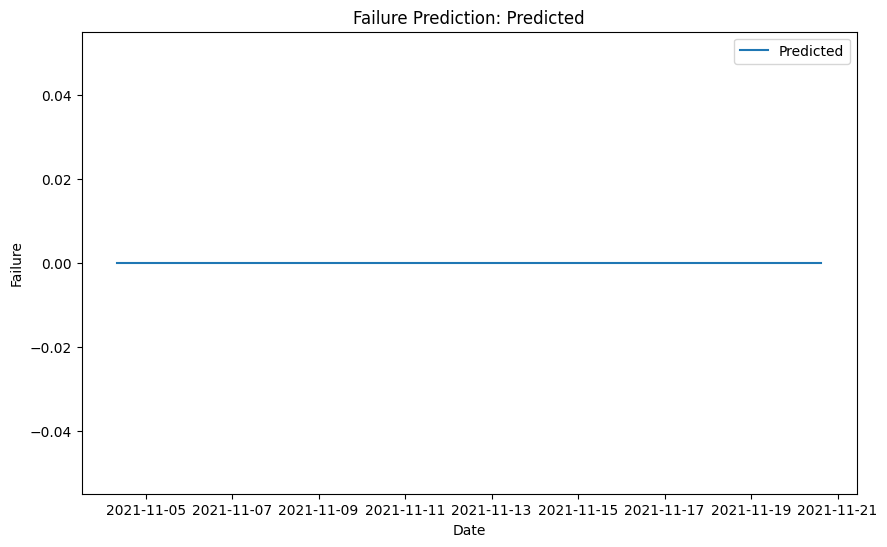

In [14]:
#Invert the predictions
test_predictions = scaler.inverse_transform(array_2d)
test_predictions = np.clip(test_predictions,0,1)
predicted_df = pd.DataFrame(test_predictions,columns=df_for_training.columns,index=test_data.index[n_steps:])



# Plot the predicted values (same as in your code)
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()

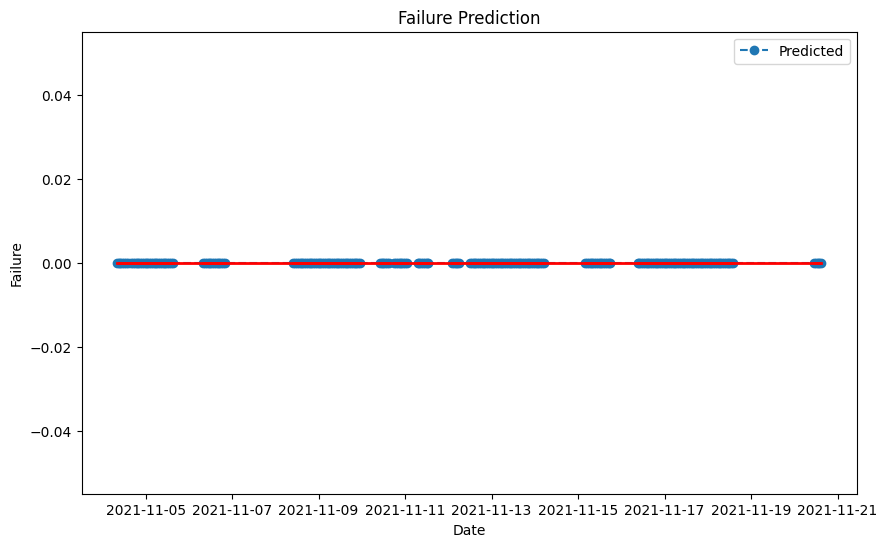

In [15]:
# Create a DataFrame for the actual values
actual_df = pd.DataFrame(test_y, columns=[target_variable], index=test_data.index[n_steps:])

# Plot the predicted and actual values with gaps
plt.figure(figsize=(10, 6))

# Plot the predicted values as a discontinuous line
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted', marker='o', linestyle='dashed')

# Plot the actual values as separate segments
for start, end in zip(actual_df.index[:-1], actual_df.index[1:]):
    plt.plot([start, end], [actual_df.loc[start, target_variable], actual_df.loc[start, target_variable]], color='red', linestyle='solid', linewidth=2)

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction')
plt.legend()
plt.show()


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Load and preprocess the dataset
failure_data = r'C:\Users\Niranjan\Desktop\BISAG\machine failed\cleaned_data.csv'
dataset = pd.read_csv(failure_data)
df = dataset
df2 = pd.DataFrame(df)
df2["Date"] = df2['Date'].astype(str) + "  " + df2['Time'].astype(str)
df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y %H:%M:%S')
df2 = df2.drop(['Time'], axis=1)
df2 = df2.set_index("Date")
df_for_training = df2.astype(float)
target_variable = 'Failure'

# Define the feature ranges
scaling_ranges = {
    'Eqp1 Load(%)': (10, 100),
    'Eqp1 Pressure1(bar)': (2.0, 3.0),
    'Eqp1 Pressure2(bar)': (7.0, 9.0),
    'Eqp1 Supply Of oil Pressure(bar) ': (7.0, 9.0),
    'Eqp1 oil filter variations Presssure(bar)': (None, 0.6),
    'Eqp1 Temp1(degree)': (5, 20),
    'Eqp1 Temp2(degree)': (50, 70),
    'Eqp1 oil temp sensor Oil level(mm)': (150, 200),
    'Eqp2 water flow(M/hr)': (90, 125),
    'Eqp2 Incoming Pressure(bar)': (-0.5, 1.5),
    'Eqp2 OutGoing Pressure(bar)': (2.0, 4.0),
    'Eqp2 Pressure(bar) Diff': (0.1, 0.1),
    'Eqp2 Incoming Temp(degree)': (10, 35),
    'Eqp2 Outgoiing Temp(degree)': (15, 40),
    'Eqp3 cold water flow (m/hr)': (75, 75),
    'Eqp3 Incoming Pressure(bar)': (-0.5, 1),
    'Eqp3 Outgoing Pressure(bar)': (4.0, 6.0),
    'Eqp3 Variation in Pressure(bar)': (0.3, None),
    'Eqp3 Incoming Temp(degree)': (12, 25),
    'Eqp3 Outgoing Temp(degree)': (6, 20),
    }

# Apply scaling ranges to the dataset
for column, (min_value, max_value) in scaling_ranges.items():
    if min_value is not None:
        df_for_training[column] = np.where(df_for_training[column] < min_value, min_value, df_for_training[column])
    if max_value is not None:
        df_for_training[column] = np.where(df_for_training[column] > max_value, max_value, df_for_training[column])

# Split the data into train and test sets based on the specified time range
train_data = df_for_training.loc[:'2022-05-15 23:00:00']
test_data = df_for_training.loc['2022-05-15 23:00:00':'2022-08-06 04:00:00']

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_days = 10
n_steps = n_days * 24

# Prepare the training data
train_X, train_y = [], []
for i in range(n_steps, len(train_data_scaled)):
    if (train_data.index[i] - train_data.index[i - n_steps]).days >= n_days:
        train_X.append(train_data_scaled[i - n_steps:i])
        train_y.append(train_data_scaled[i, df_for_training.columns.get_loc('Failure')])
train_X, train_y = np.array(train_X), np.array(train_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    if (test_data.index[i] - test_data.index[i - n_steps]).days >= n_days:
        test_X.append(test_data_scaled[i - n_steps:i])
        test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)

# Prepare the test data
test_X, test_y = [], []
for i in range(n_steps, len(test_data_scaled)):
    test_X.append(test_data_scaled[i - n_steps:i])
    test_y.append(test_data_scaled[i, df_for_training.columns.get_loc('Failure')])
test_X, test_y = np.array(test_X), np.array(test_y)
# Define the architecture of the Transformer model
encoder_inputs = Input(shape=(n_steps, n_features))
encoder = layers.Dropout(0.1)(encoder_inputs)
encoder = layers.Dense(64, activation="relu")(encoder)
encoder = layers.Dense(32, activation="relu")(encoder)

decoder_inputs = layers.Dense(32, activation="relu")(encoder)
decoder = layers.Dense(64, activation="relu")(decoder_inputs)
decoder = layers.Dense(n_features)(decoder)

# Define the model
model = Model(encoder_inputs, decoder)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Train the model
model.fit(train_X, train_X, epochs=10, batch_size=16, validation_data=(test_X, test_X), 
          callbacks=[EarlyStopping(patience=3)], verbose=1)

# Make predictions on the test data
test_predictions = model.predict(test_X)

Epoch 1/10
113/113 [==============================] - 3s 11ms/step - loss: 0.1829 - val_loss: 0.2347
Epoch 2/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0678 - val_loss: 0.1742
Epoch 3/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0507 - val_loss: 0.0703
Epoch 4/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0400 - val_loss: 0.0697
Epoch 5/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0375 - val_loss: 0.0689
Epoch 6/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0356 - val_loss: 0.0658
Epoch 7/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0338 - val_loss: 0.0614
Epoch 8/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0321 - val_loss: 0.0609
Epoch 9/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0310 - val_loss: 0.0618
Epoch 10/10
10/10 [==============================] - 0s 6ms/step


In [36]:
test_predictions.shape
array_2d = np.mean(test_predictions,axis =1)
array_2d.shape

(291, 26)

In [37]:
test_predictions = scaler.inverse_transform(array_2d)
test_predictions = np.clip(test_predictions,0,1)


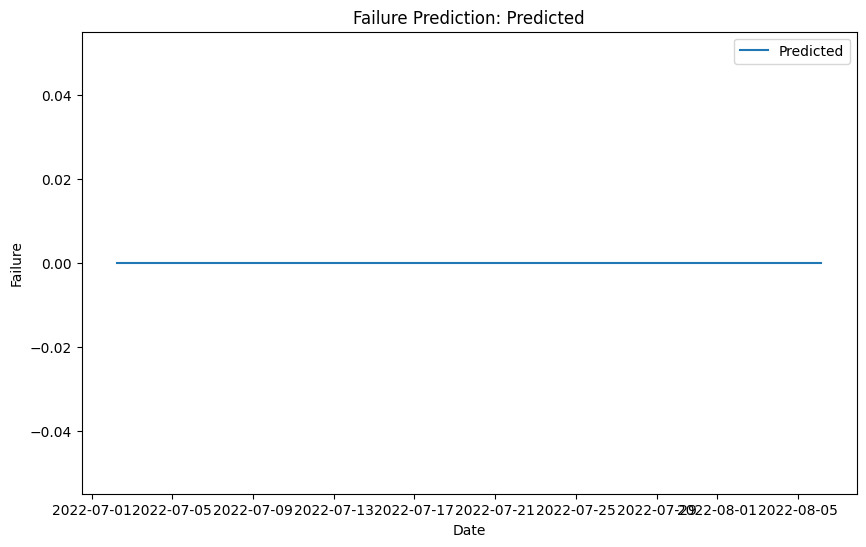

In [33]:
predicted_df = pd.DataFrame(test_predictions,columns=df_for_training.columns,index=test_data.index[n_steps:])



# Plot the predicted values (same as in your code)
plt.figure(figsize=(10, 6))
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction: Predicted')
plt.legend()
plt.show()

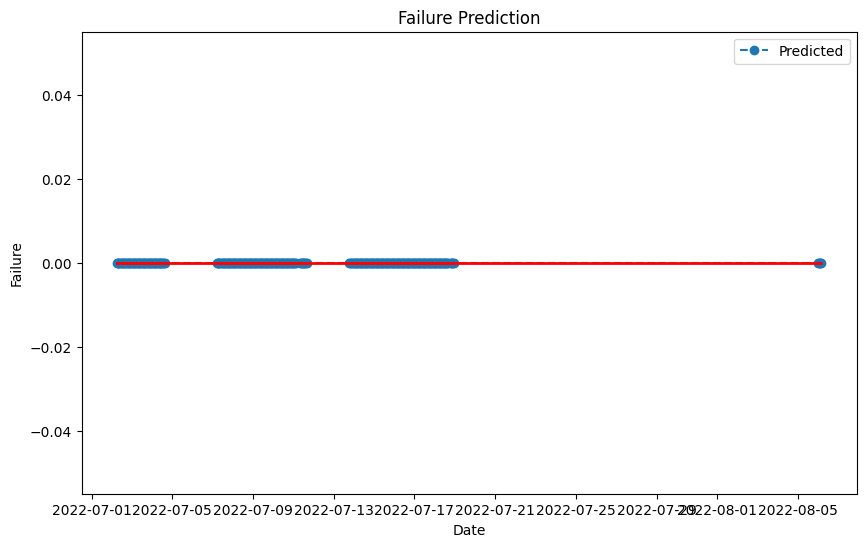

In [34]:
# Create a DataFrame for the actual values
actual_df = pd.DataFrame(test_y, columns=[target_variable], index=test_data.index[n_steps:])

# Plot the predicted and actual values with gaps
plt.figure(figsize=(10, 6))

# Plot the predicted values as a discontinuous line
plt.plot(predicted_df.index, predicted_df[target_variable], label='Predicted', marker='o', linestyle='dashed')

# Plot the actual values as separate segments
for start, end in zip(actual_df.index[:-1], actual_df.index[1:]):
    plt.plot([start, end], [actual_df.loc[start, target_variable], actual_df.loc[start, target_variable]], color='red', linestyle='solid', linewidth=2)

plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Failure Prediction')
plt.legend()
plt.show()
